In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cmath import nan
import os
import re
import numpy as np 
import pandas as pd
import math
import click
import json

from pymatgen.core import Structure

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
def min_max(numbers):
    a = np.min(numbers)
    b = np.max(numbers)
    return (numbers-a)/(b-a)

In [3]:
ch4_sigma , ch4_epsilon = 3.73, 148
c_sigma, c_epsilon = 2.8, 27.0
o_sigma, o_epsilon = 3.05, 79.0
uff = pd.read_csv("./ff_data/uff.csv")

In [4]:
threshold = 15

In [5]:
nvt_path = "./nvt_results"
rst_path = "./parse_results_co2"

In [6]:
structure_lst = os.listdir(nvt_path)
structure_lst

['WOGHOP_clean']

In [7]:
structure = structure_lst[0]

# Data preparation

## Get supercell

In [8]:
def get_supercell(structure):
    with open("nvt_results/%s/simulation.input" %structure, "r") as f_input:
        for line in f_input:
            if re.search("UnitCells", line):
                s1, s2, s3 = line.split()[1], line.split()[2], line.split()[3]
    supercell = np.array([int(s1), int(s2), int(s3)])
    return supercell

In [9]:
sc = get_supercell(structure)

In [13]:
sc

array([3, 2, 2])

## Get lattice

In [10]:
def get_lattice(structure):
    with open("nvt_results/%s/Movies/System_0/Framework_final.pdb" %structure) as file:
        lines = file.readlines()
        lattice = np.array([float(l) for l in lines[1].split()[1:4]])
        frame_ele = np.array([l.split()[2] for l in lines[2:]])
        frame_pos = np.array([[float(t) for t in l.split()[4:7]] for l in lines[2:]])
    return lattice, frame_ele, frame_pos

In [11]:
latt, ele, pos = get_lattice(structure)

In [12]:
latt

array([32.488, 25.493, 24.794])

In [13]:
len(ele)

1920

# read gas pos

In [13]:
with open(os.path.join(nvt_path, "%s/Movies/System_0/Movie_%s_%d.%d.%d_298.000000_0.000000_allcomponents.pdb" %(structure, structure, sc[0], sc[1], sc[2]))) as file:
        data = file.readlines()
        positions = np.array([line.split() for line in data if "ATOM" in line])
        pos_c = np.array([[float(t) for t in l[4:7]] for l in positions if l[1] == '2'])
        pos_o1 = np.array([[float(t) for t in l[4:7]] for l in positions if l[1] == '1'])
        pos_o2 = np.array([[float(t) for t in l[4:7]] for l in positions if l[1] == '3'])
    

# calculate distance

In [14]:
dist_c = np.array([np.abs([atom-c for atom in pos]) for c in pos_c])

In [15]:
dist_c = np.array([[[l-r if r>l/2 else r for r,l in zip(a, latt)] for a in s] for s in dist_c])

In [16]:
dist_c *= dist_c

In [17]:
dist_c = np.sum(dist_c, axis=2)

In [18]:
dist_c = np.sqrt(dist_c)

In [213]:
dist_c.shape

(10000, 1248)

(array([ 16.,  55.,  75., 134., 203., 265., 240., 152.,  87.,  21.]),
 array([ 2.2089373 ,  4.25088399,  6.29283068,  8.33477737, 10.37672406,
        12.41867075, 14.46061745, 16.50256414, 18.54451083, 20.58645752,
        22.62840421]),
 <BarContainer object of 10 artists>)

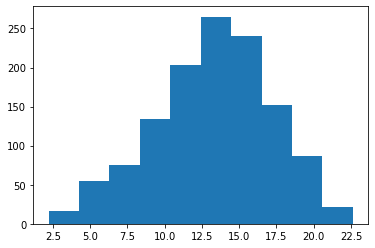

In [214]:
plt.hist(dist_c[0])

In [19]:
dist_o1 = np.array([np.abs([atom-o for atom in pos]) for o in pos_o1])
dist_o1 = np.array([[[l-r if r>l/2 else r for r,l in zip(a, latt)] for a in s] for s in dist_o1])
dist_o1 *= dist_o1
dist_o1 = np.sum(dist_o1, axis=2)
dist_o1 = np.sqrt(dist_o1)

In [20]:
    dist_o2 = np.array([np.abs([atom-o for atom in pos]) for o in pos_o2])
    dist_o2 = np.array([[[l-r if r>l/2 else r for r,l in zip(a, latt)] for a in s] for s in dist_o2])
    dist_o2 *= dist_o2
    dist_o2 = np.sum(dist_o2, axis=2)
    dist_o2 = np.sqrt(dist_o2)

## Read force field

### Read ff with LB mixing rule

In [52]:
uff = pd.read_csv("ff_data/uff.csv")

In [53]:
uff

,Unnamed: 0,element,epsilon,sigma,lb_sigma,lb_epsilon
0,0,Ac,16.6080,3.0985,3.399618,82.30400
1,1,Ag,18.1178,2.8045,3.234314,83.05890
2,2,Al,254.1520,4.0082,3.866599,201.07600
3,3,Am,7.0458,3.0121,3.351885,77.52290
4,4,Ar,93.1052,3.4460,3.585189,120.55260
...,...,...,...,...,...,...
98,98,Xe,167.0861,3.9235,3.825527,157.54305
99,99,Y,36.2355,2.9801,3.334033,92.11775
100,100,Yb,114.7458,2.9890,3.339007,131.37290
101,101,Zn,62.4056,2.4616,3.030143,105.20280


In [21]:
ele_sigma = [uff[uff["element"]==e]["sigma"].item() for e in ele]
ele_epsilon = [uff[uff["element"]==e]["epsilon"].item() for e in ele]

In [22]:
ele_sigma_c = [(uff[uff["element"]==e]["sigma"].item()+c_sigma)/2 for e in ele]
ele_epsilon_c = [np.sqrt(uff[uff["element"]==e]["epsilon"].item()*c_epsilon) for e in ele]

In [23]:
ele_sigma_o = [(uff[uff["element"]==e]["sigma"].item()+o_sigma)/2 for e in ele]
ele_epsilon_o = [np.sqrt(uff[uff["element"]==e]["epsilon"].item()*o_epsilon) for e in ele]

# Calculate potentials

In [47]:
poten_c = np.array([ele_epsilon_c*((ele_sigma_c/r)**12-(ele_sigma_c/r)**6) for r in dist_c])

(0.0, 100.0)

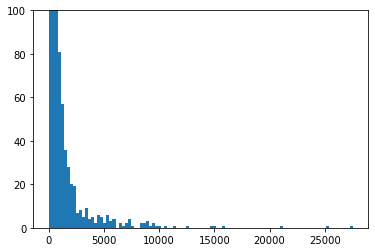

In [251]:
plt.hist(poten_c.flatten(), bins=100)
plt.ylim(0,100)

In [65]:
avg_poten_c = np.average(poten_c, axis=0)

## sum potential for C and O

In [48]:
poten_o1 = np.array([ele_epsilon_o*((ele_sigma_o/r)**12-(ele_sigma_o/r)**6) for r in dist_o1])
poten_o2 = np.array([ele_epsilon_o*((ele_sigma_o/r)**12-(ele_sigma_o/r)**6) for r in dist_o2])

In [69]:
avg_poten_o1 = np.average(poten_o1, axis=0)
avg_poten_o2 = np.average(poten_o2, axis=0)

In [70]:
avg_poten = np.array([c+o1+o2 for c, o1, o2 in zip(avg_poten_c, avg_poten_o1, avg_poten_o2)])

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 2.000e+0

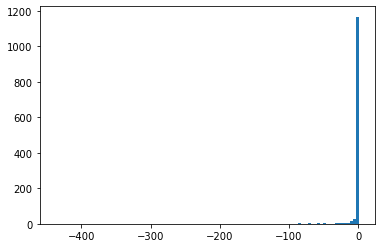

In [71]:
plt.hist(avg_poten, bins=100)

# potential normalization

## map avg_potential to one unit cell

In [33]:
num_uc = sc[0] * sc[1] * sc[2]
num_at = int(len(pos) / num_uc)

# Visulization

In [62]:
from ase_notebook import AseView, ViewConfig

In [63]:
cif = Structure.from_file("nvt_results/%s/%s.cif" %(structure, structure))

In [64]:
cif.add_site_property("weight", weight_uc.reshape(-1,))

In [65]:
config = ViewConfig()
config.atom_font_size=10
config.axes_length=30
config.canvas_size=(500, 500)
config.zoom=1.2
config.show_bonds=True
config.atom_color_by = "value_array"
config.atom_color_array = "weight"
config.atom_colormap = "Greens"
config.atom_colormap_range = (0, 1)

get_element_radii


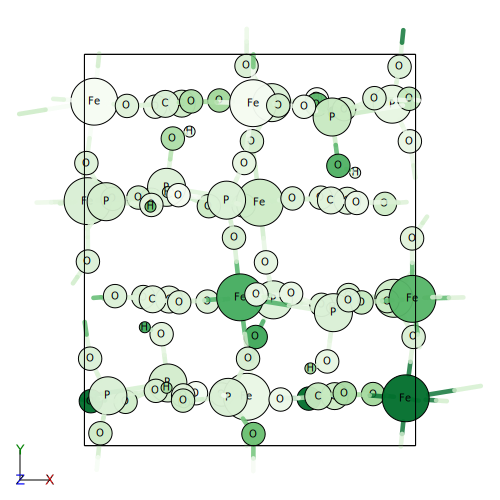

In [66]:
ase_view = AseView(config)
gui = ase_view.make_svg(
    cif, center_in_uc=True)
gui

# plot uff

In [68]:
r = np.arange(2.1, 10, 0.001)

In [70]:
sigma = np.array(uff["sigma"])
epsilon = np.array(uff["epsilon"])

In [71]:
lj = np.array([e*((s/r)**12-(s/r)**6) for e, s in zip(epsilon, sigma)])

In [162]:
uff[uff["element"]=="Mg"]

,Unnamed: 0,element,epsilon,sigma,lb_sigma,lb_epsilon
51,51,Mg,55.8631,2.6914,3.168426,101.93155


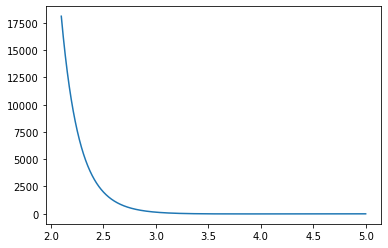

In [163]:
plt.plot(r, lj[14])


In [72]:
in_ele = np.array(uff["element"])

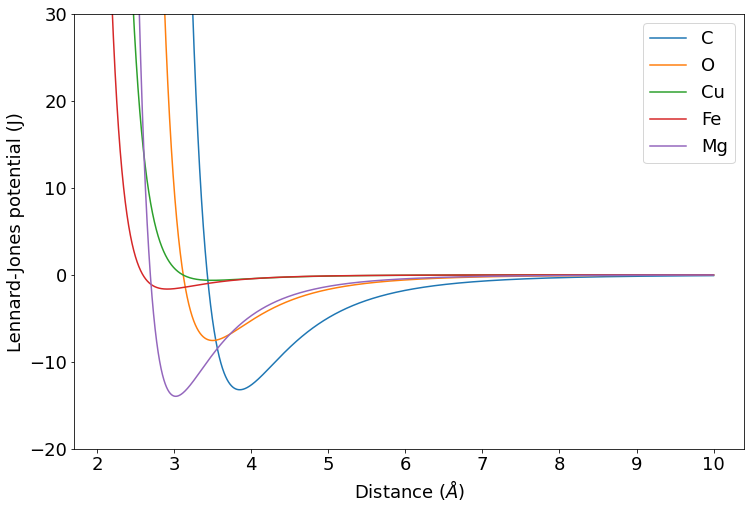

In [73]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(12,8))
for ids in [14,62,24,30,51]:
    plt.plot(r, lj[ids], label=in_ele[ids])

plt.ylim(-20, 30)
plt.legend()
plt.xlabel("Distance ($\AA$)")
plt.ylabel("Lennard-Jones potential (J)")

plt.savefig("plots/LJ.png")

# classify repulsion and attraction

### variables required
- distances: dist_c, dist_o1, dist_o2
- uff parameters: ele_sigma_c, ele_epsilon_c, ele_sigma_o, ele_epsilon_o
- framework atom element: ele

In [49]:
for s in range(poten_c.shape[0]):
    poten_c[s][np.where(dist_c[s]<ele_sigma_c)[0]] = 0
    poten_o1[s][np.where(dist_o1[s]<ele_sigma_o)[0]] = 0
    poten_o2[s][np.where(dist_o2[s]<ele_sigma_o)[0]] = 0

potential = poten_c + poten_o1 + poten_o2


In [37]:
potential.shape

(10000, 1248)

In [54]:
distances = (dist_c+dist_o1+dist_o2)/3

In [56]:
for i in range(num_uc):
    if i == 0:
        distances_uc = distances[0:num_at]
        potential_uc = potential[0:num_at]
    else:
        distances_uc += distances[i*num_at:(i+1)*num_at]
        potential_uc += potential[i*num_at:(i+1)*num_at]

distances_uc /= num_uc
potential_uc /= num_uc

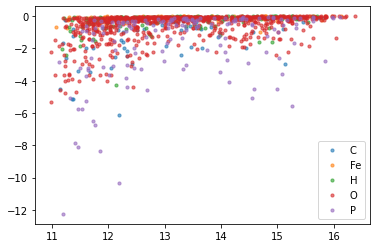

In [60]:
ele_uni = np.unique(ele)

for e in ele_uni:
    plt.scatter(distances_uc[0][ele==e], potential_uc[0][ele==e], s=10, label=e, alpha=0.6)

plt.legend()

In [381]:
potential.shape

(10000, 1248)

In [30]:
weight = min_max(np.average(potential, axis=0))

In [61]:
for i in range(num_uc):
    if i == 0:
        weight_uc = weight[0:num_at]
    else:
        weight_uc += weight[i*num_at:(i+1)*num_at]

weight_uc /= num_uc

(array([15., 43., 26.,  3.,  5.,  2.,  4.,  2.,  0.,  4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

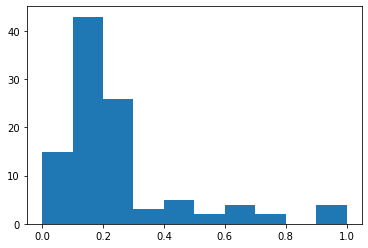

In [35]:
plt.hist(min_max(weight_uc))

In [390]:
min_max(weight_uc)[ele[0:num_at]=="Fe"]

array([4.11161428e-03, 9.43838352e-03, 1.30834994e-02, 5.19279100e-06,
       3.17795933e-03, 9.85308574e-03, 1.46540845e-02, 0.00000000e+00])

In [386]:
ele[0:num_at]#[min_max(weight_uc)>0.8]

array(['Fe', 'Fe', 'P', 'P', 'P', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'H', 'O', 'H', 'O', 'H', 'O', 'C', 'C',
       'Fe', 'Fe', 'P', 'P', 'P', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'H', 'O', 'H', 'O', 'H', 'O', 'C', 'C',
       'Fe', 'Fe', 'P', 'P', 'P', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'H', 'O', 'H', 'O', 'H', 'O', 'C', 'C',
       'Fe', 'Fe', 'P', 'P', 'P', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'H', 'O', 'H', 'O', 'H', 'O', 'C', 'C'],
      dtype='<U2')

In [114]:
cif = Structure.from_file("nvt_results/%s/%s.cif" %(structure, structure))

In [130]:
pos_c.shape

(10000, 3)

In [128]:
neighbor_dist = [nn.nn_distance for nn in cif.get_sites_in_sphere(pos_c[0], 3)]

In [129]:
neighbor_dist

[2.353719278443252,
 2.384694769333993,
 2.6912826599529507,
 1.775820680502945,
 2.8161839640507074,
 2.4024135448289012]

In [111]:
cif.sites[0].distance_from_point(pos_c[0])

18.09523893195973

In [131]:
nn = np.array([cif.get_sites_in_sphere(c, threshold) for c in pos_c], dtype=object)

/home/xiaoqi/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [132]:
nn_dist = np.array([[n.nn_distance for n in s] for s in nn], dtype=object)

In [138]:
len(nn_dist[1])/12

71.91666666666667